#### 利用训练模型进行遥感影像分类

In [ ]:
import pickle
import numpy as np
import rasterio as rio
from matplotlib import colors
import matplotlib.pyplot as plt


In [2]:
path_model = 'data/Section-7/model_rf.pickle'
path_rsimg= 'data/Section-7/s2_kunming_chenggong_6bands_20m.tif'


In [3]:
## 读入栅格数据
rsimg_rio = rio.open(path_rsimg)
rsimg_rio.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1497,
 'height': 1611,
 'count': 6,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(20.0, 0.0, 268180.0,
        0.0, -20.0, 2765440.0)}

In [4]:
rsimg_arr = rsimg_rio.read()
rsimg_arr = rsimg_arr.transpose(1,2,0)
rsimg_arr.shape


(1611, 1497, 6)

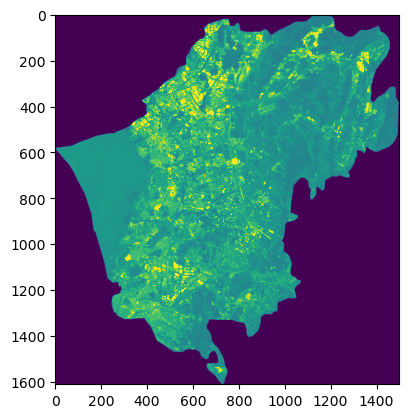

In [5]:
plt.imshow(rsimg_arr[:,:,0], vmax=3000)


In [6]:
### 归一化
rsimg_arr_nor = rsimg_arr/(10000-0)
rsimg_arr_nor.shape

(1611, 1497, 6)

In [7]:
rsimg_arr_2d = rsimg_arr_nor.reshape(-1,6)
rsimg_arr_2d.shape


(2411667, 6)

In [8]:
## 模型加载
with open(path_model, 'rb') as file:
  model_rf = pickle.load(file)


##### 模型预测

In [9]:
y_pred = model_rf.predict(rsimg_arr_2d)


In [10]:
y_pred.shape


(2411667,)

In [11]:
y_pred_img = y_pred.reshape(rsimg_arr.shape[0:2])
y_pred_img.shape


(1611, 1497)

In [12]:
ids = np.where(rsimg_arr[:,:,0]==0)
# y_pred_img = np.float32(y_pred_img)  ### 不能对整型数据赋值np.nan.
y_pred_img[ids] = -1  ## 去除无数据区域


##### 可视化结果

In [ ]:
### 对不同类别分类结果赋不同彩色像元值
color_list = {0: np.array([0,0,255]),      # water, blue
              1: np.array([0,128,0]),      # land, green
              } 
y_pred_img_color = np.full(shape=(y_pred_img.shape[0], 
                                  y_pred_img.shape[1], 3), 
                                  fill_value=-1)

for color_code in color_list.keys():
    y_pred_img_color[y_pred_img==color_code] = color_list[color_code]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..255].


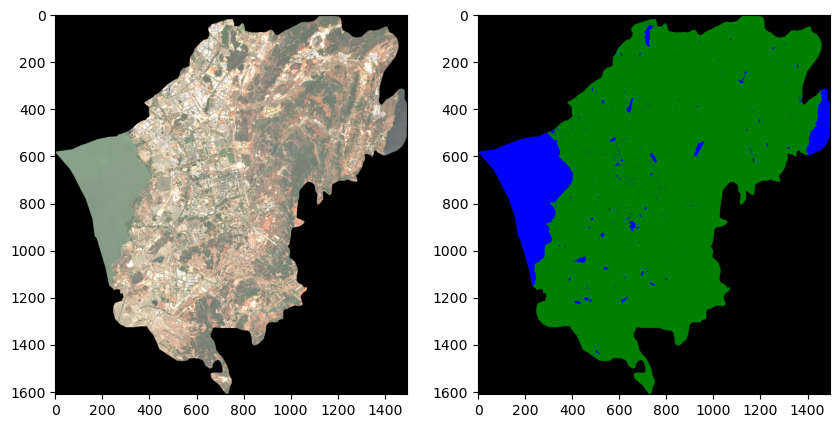

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
band_color = np.stack([rsimg_arr_nor[:,:,2], 
                       rsimg_arr_nor[:,:,1], 
                       rsimg_arr_nor[:,:,0]], axis=2)   ### rgb: red:green:blue;
band_color = band_color/(0.3-0)    ### 线性拉伸
ax[0].imshow(band_color)           ### 彩色显示
ax[1].imshow(y_pred_img_color)


In [ ]:
#### 分类结果保存
# path_result = 'data/Section-7/class_result.tif'
# with rio.open(path_result, 'w', driver='GTiff', 
#                    height=y_pred_img.shape[0],
#                    width=y_pred_img.shape[1],
#                    count=1,
#                    dtype=np.int16,
#                    crs=rsimg_rio.crs,
#                    transform=rsimg_rio.transform) as dst:
#   dst.write(y_pred_img, 1)   ## the number 1 is the number of bands.
